In [1]:
from functools import partial
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet50
import torchmetrics

In [2]:
batch_size = 256
max_epochs = 40

A transfomr similar to simCLR augmentations to create distorted images:

In [3]:
class BarlowTwinsTransform:
    def __init__(self, input_height=32, jitter_strength=0.5, normalize = True):
        self.input_height = input_height
        self.jitter_strength = jitter_strength

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        self.color_transform = transforms.Compose([transforms.RandomApply([color_jitter], p=0.5), transforms.RandomGrayscale(p=0.2)])

        normalization = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])

        if normalize:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalization])
        else:
            self.final_transform = transforms.ToTensor()

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.4),
                self.color_transform,
                self.final_transform,
            ]
        )


    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.final_transform(sample)

Visualizing some sample images and their augmented versions:

Files already downloaded and verified


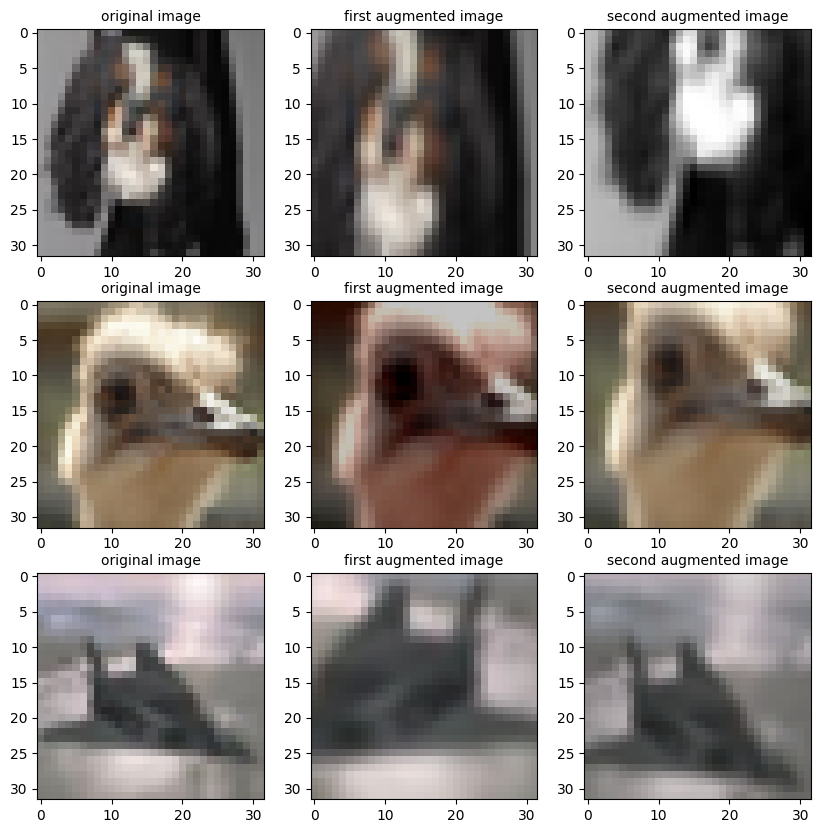

In [4]:
example_transform = BarlowTwinsTransform(normalize = False)
example_dataset = CIFAR10(root=".", train=False, download=True, transform=example_transform)

plt.figure(figsize=(10,10))
samples = np.random.randint(0, len(example_dataset), size=3)
for i, num in enumerate(samples):
    (img1, img2, img3), label = example_dataset.__getitem__(num)
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(np.transpose(img1, (1, 2, 0)))
    plt.title("first augmented image", fontsize=10)
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(np.transpose(img2, (1, 2, 0)))
    plt.title("second augmented image", fontsize=10)
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(np.transpose(img3, (1, 2, 0)))
    plt.title("original image", fontsize=10)
plt.show()

Preparing the datasets:

In [5]:
train_transform = BarlowTwinsTransform()
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)
val_transform = BarlowTwinsTransform()
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


Module for calculating the barlow twins loss. In simple terms, it aims to make the cross correlation matrix between the embeddings of the two distorted pictures close to the identity matrix:

In [6]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=0.0051):
        super().__init__()
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)
        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size
        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()
        return on_diag + self.lambda_coeff * off_diag

Creating a resnet50 module with randomly initialized weights and removing the last linear layer:

In [7]:
backbone = resnet50()
backbone.fc = nn.Identity()

A projector module to create the embeddings from the representations learned by the backbone module:

In [8]:
class Projector(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=1024):
        super().__init__()

        self.projector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=True)
        )

    def forward(self, x):
        return self.projector(x)

Linear learning rate warmup, a simpler approach than the one used in the original paper:

In [9]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0

def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

The full barlow twins module:

In [10]:
class BarlowTwins(L.LightningModule):
    def __init__(
        self,
        backbone,
        num_training_samples,
        batch_size,
        max_epochs,
        lambda_coeff=0.0051,
        learning_rate=0.001,
        warmup_epochs=10,
    ):
        super().__init__()

        self.backbone = backbone
        self.projector = Projector()
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size)
        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.backbone(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch
        z1 = self.projector(self.backbone(x1))
        z2 = self.projector(self.backbone(x2))
        return self.loss_fn(z1, z2)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar = True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }
        return [optimizer], [scheduler]

Creating the model and trainer:

In [11]:
model = BarlowTwins(
    backbone=backbone,
    num_training_samples=len(train_dataset),
    batch_size=batch_size,
    max_epochs=max_epochs
)
model = model.to('cuda')

trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training the self supervised model:

In [12]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | backbone  | ResNet          | 23.5 M
1 | projector | Projector       | 10.5 M
2 | loss_fn   | BarlowTwinsLoss | 0     
----------------------------------------------
34.0 M    Trainable params
0         Non-trainable params
34.0 M    Total params
136.028   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


Classifier module that takes the trained resnet50 backbone and uses it for CIFAR-10 classification:

In [13]:
class Classifier(L.LightningModule):
  def __init__(self, model, training, learning_rate = 0.0005):
    super().__init__()
    self.model = model
    self.learning_rate = learning_rate
    self.trainer = trainer
    self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    self.f1score = torchmetrics.F1Score(task="multiclass", num_classes=10)
    self.relu1 = nn.ReLU()
    self.linear1 = nn.Linear(in_features=2048, out_features=1024, bias=True)
    self.relu2 = nn.ReLU()
    self.linear2 = nn.Linear(in_features=1024, out_features=256, bias=True)
    self.relu3 = nn.ReLU()
    self.linear3 = nn.Linear(in_features=256, out_features=10, bias=True)
    self.epoch = 0

  def forward(self, x):
    x = self.model(x)
    x = self.relu1(x)
    x = self.linear1(x)
    x = self.relu2(x)
    x = self.linear2(x)
    x = self.relu3(x)
    x = self.linear3(x)
    return x

  def training_step(self, batch, batch_idx):
    (_, _, img), labels = batch
    preds = self(img)
    loss = F.cross_entropy(preds, labels)
    acc = self.accuracy(preds, labels)
    self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar = True)
    self.log("train_acc", acc, prog_bar = True)
    return loss

  def validation_step(self, batch, batch_idx):
    (_, _, img), labels = batch
    preds = self(img)
    loss = F.cross_entropy(preds, labels)
    acc = self.accuracy(preds, labels)
    self.log("val_loss", loss, prog_bar = True)
    self.log("val_acc", acc, prog_bar = True)
    return loss

  def test_step(self, batch, batch_idx):
    (_, _, img), labels = batch
    preds = self(img)
    loss = F.cross_entropy(preds, labels)
    acc = self.accuracy(preds, labels)
    f1 = self.f1score(preds, labels)
    self.log("test_loss", loss, prog_bar = True)
    self.log("test_acc", acc, prog_bar = True)
    self.log("test_f1", f1, prog_bar = True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    scheduler = {
        "scheduler": torch.optim.lr_scheduler.LambdaLR(
            optimizer,
            linear_warmup_decay(620),
        ),
        "interval": "step",
        "frequency": 1,
        }
    return [optimizer], [scheduler]

  def on_train_epoch_end(self):
        print("epoch", self.epoch)
        self.epoch +=1
        print(self.trainer.progress_bar_metrics)

Creating the model and the trainer:

In [14]:
trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trained_backbone = model.backbone
for param in trained_backbone.parameters():
  param.requires_grad = False
trained_backbone.fc = nn.Linear(in_features=2048, out_features=2048, bias=True)
supervised_model = Classifier(trained_backbone, trainer).to('cuda')

Preparing the datasets:

In [16]:
transform = BarlowTwinsTransform()
dataset = CIFAR10(root=".", train=False, download=True, transform=transform)
train_dataset2, test_dataset = torch.utils.data.random_split(dataset, [8000, 2000])
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

Files already downloaded and verified


Training the supervised model: 

In [17]:
trainer.fit(supervised_model, train_loader2, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 27.7 M
1 | accuracy | MulticlassAccuracy | 0     
2 | f1score  | MulticlassF1Score  | 0     
3 | relu1    | ReLU               | 0     
4 | linear1  | Linear             | 2.1 M 
5 | relu2    | ReLU               | 0     
6 | linear2  | Linear             | 262 K 
7 | relu3    | ReLU               | 0     
8 | linear3  | Linear             | 2.6 K 
------------------------------------------------
6.6 M     Trainable params
23.5 M    Non-trainable params
30.1 M    Total params
120.270   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/askari/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 0
{'train_loss_step': 1.7750208377838135, 'train_acc': 0.4296875, 'val_loss': 1.7671009302139282, 'val_acc': 0.4341517984867096, 'train_loss_epoch': 2.1453306674957275}


Validation: 0it [00:00, ?it/s]

epoch 1
{'train_loss_step': 1.2615506649017334, 'train_acc': 0.56640625, 'val_loss': 1.3362324237823486, 'val_acc': 0.5089285969734192, 'train_loss_epoch': 1.4456071853637695}


Validation: 0it [00:00, ?it/s]

epoch 2
{'train_loss_step': 1.2587209939956665, 'train_acc': 0.5546875, 'val_loss': 1.307183861732483, 'val_acc': 0.51953125, 'train_loss_epoch': 1.3116681575775146}


Validation: 0it [00:00, ?it/s]

epoch 3
{'train_loss_step': 1.2469109296798706, 'train_acc': 0.5625, 'val_loss': 1.2981367111206055, 'val_acc': 0.5184151530265808, 'train_loss_epoch': 1.26497483253479}


Validation: 0it [00:00, ?it/s]

epoch 4
{'train_loss_step': 1.2260136604309082, 'train_acc': 0.5703125, 'val_loss': 1.2865207195281982, 'val_acc': 0.5167410969734192, 'train_loss_epoch': 1.2403695583343506}


Validation: 0it [00:00, ?it/s]

epoch 5
{'train_loss_step': 1.197851300239563, 'train_acc': 0.56640625, 'val_loss': 1.2778412103652954, 'val_acc': 0.5234375, 'train_loss_epoch': 1.2181921005249023}


Validation: 0it [00:00, ?it/s]

epoch 6
{'train_loss_step': 1.1804986000061035, 'train_acc': 0.5703125, 'val_loss': 1.2785462141036987, 'val_acc': 0.5318080186843872, 'train_loss_epoch': 1.1954041719436646}


Validation: 0it [00:00, ?it/s]

epoch 7
{'train_loss_step': 1.1647453308105469, 'train_acc': 0.5625, 'val_loss': 1.2875444889068604, 'val_acc': 0.5245535969734192, 'train_loss_epoch': 1.177437424659729}


Validation: 0it [00:00, ?it/s]

epoch 8
{'train_loss_step': 1.1461013555526733, 'train_acc': 0.5703125, 'val_loss': 1.2785896062850952, 'val_acc': 0.5290178656578064, 'train_loss_epoch': 1.162389874458313}


Validation: 0it [00:00, ?it/s]

epoch 9
{'train_loss_step': 1.112803339958191, 'train_acc': 0.5859375, 'val_loss': 1.2747992277145386, 'val_acc': 0.5301339030265808, 'train_loss_epoch': 1.1457206010818481}


Validation: 0it [00:00, ?it/s]

epoch 10
{'train_loss_step': 1.0889670848846436, 'train_acc': 0.58203125, 'val_loss': 1.278355360031128, 'val_acc': 0.53125, 'train_loss_epoch': 1.1303566694259644}


Validation: 0it [00:00, ?it/s]

epoch 11
{'train_loss_step': 1.0596699714660645, 'train_acc': 0.6171875, 'val_loss': 1.2782020568847656, 'val_acc': 0.53125, 'train_loss_epoch': 1.1093872785568237}


Validation: 0it [00:00, ?it/s]

epoch 12
{'train_loss_step': 1.0748990774154663, 'train_acc': 0.609375, 'val_loss': 1.2890799045562744, 'val_acc': 0.5251116156578064, 'train_loss_epoch': 1.0965384244918823}


Validation: 0it [00:00, ?it/s]

epoch 19
{'train_loss_step': 1.0094125270843506, 'train_acc': 0.62890625, 'val_loss': 1.3801356554031372, 'val_acc': 0.5178571343421936, 'train_loss_epoch': 1.01032292842865}


Validation: 0it [00:00, ?it/s]

epoch 20
{'train_loss_step': 1.0920600891113281, 'train_acc': 0.56640625, 'val_loss': 1.4276540279388428, 'val_acc': 0.5044642686843872, 'train_loss_epoch': 1.0202744007110596}


Validation: 0it [00:00, ?it/s]

epoch 21
{'train_loss_step': 0.9686609506607056, 'train_acc': 0.62890625, 'val_loss': 1.4832658767700195, 'val_acc': 0.5122767686843872, 'train_loss_epoch': 0.9387341141700745}


Validation: 0it [00:00, ?it/s]

epoch 22
{'train_loss_step': 0.9543148875236511, 'train_acc': 0.6640625, 'val_loss': 1.5542384386062622, 'val_acc': 0.5184151530265808, 'train_loss_epoch': 0.9026792645454407}


Validation: 0it [00:00, ?it/s]

epoch 23
{'train_loss_step': 0.8749223351478577, 'train_acc': 0.68359375, 'val_loss': 1.6283246278762817, 'val_acc': 0.5011160969734192, 'train_loss_epoch': 0.8922498822212219}


Validation: 0it [00:00, ?it/s]

epoch 24
{'train_loss_step': 0.8538379669189453, 'train_acc': 0.69140625, 'val_loss': 1.548965573310852, 'val_acc': 0.5122767686843872, 'train_loss_epoch': 0.9123734831809998}


Validation: 0it [00:00, ?it/s]

epoch 25
{'train_loss_step': 0.772990882396698, 'train_acc': 0.7109375, 'val_loss': 1.5338791608810425, 'val_acc': 0.5368303656578064, 'train_loss_epoch': 0.8772628307342529}


Validation: 0it [00:00, ?it/s]

epoch 26
{'train_loss_step': 0.7773551344871521, 'train_acc': 0.69140625, 'val_loss': 1.557983160018921, 'val_acc': 0.5200892686843872, 'train_loss_epoch': 0.8448436856269836}


Validation: 0it [00:00, ?it/s]

epoch 27
{'train_loss_step': 0.7275968194007874, 'train_acc': 0.73828125, 'val_loss': 1.6578525304794312, 'val_acc': 0.52734375, 'train_loss_epoch': 0.7972981333732605}


Validation: 0it [00:00, ?it/s]

epoch 28
{'train_loss_step': 0.7246775031089783, 'train_acc': 0.73046875, 'val_loss': 1.7087039947509766, 'val_acc': 0.5178571343421936, 'train_loss_epoch': 0.7548605799674988}


Validation: 0it [00:00, ?it/s]

epoch 29
{'train_loss_step': 0.7815285325050354, 'train_acc': 0.69921875, 'val_loss': 1.738261103630066, 'val_acc': 0.4977678656578064, 'train_loss_epoch': 0.7433078289031982}


Validation: 0it [00:00, ?it/s]

epoch 30
{'train_loss_step': 0.7616059184074402, 'train_acc': 0.73046875, 'val_loss': 1.7101552486419678, 'val_acc': 0.4949776828289032, 'train_loss_epoch': 0.7594495415687561}


Validation: 0it [00:00, ?it/s]

epoch 31
{'train_loss_step': 0.8448551893234253, 'train_acc': 0.65625, 'val_loss': 1.779300570487976, 'val_acc': 0.4860491156578064, 'train_loss_epoch': 0.7673789262771606}


Validation: 0it [00:00, ?it/s]

epoch 32
{'train_loss_step': 0.6719532012939453, 'train_acc': 0.76953125, 'val_loss': 1.8825228214263916, 'val_acc': 0.515625, 'train_loss_epoch': 0.7146625518798828}


Validation: 0it [00:00, ?it/s]

epoch 33
{'train_loss_step': 0.5787146687507629, 'train_acc': 0.80078125, 'val_loss': 1.9184563159942627, 'val_acc': 0.5150669813156128, 'train_loss_epoch': 0.6536682844161987}


Validation: 0it [00:00, ?it/s]

epoch 34
{'train_loss_step': 0.5140717625617981, 'train_acc': 0.83203125, 'val_loss': 2.0124244689941406, 'val_acc': 0.51953125, 'train_loss_epoch': 0.608500599861145}


Validation: 0it [00:00, ?it/s]

epoch 35
{'train_loss_step': 0.548926830291748, 'train_acc': 0.796875, 'val_loss': 2.0472588539123535, 'val_acc': 0.4966517984867096, 'train_loss_epoch': 0.5827962756156921}


Validation: 0it [00:00, ?it/s]

epoch 36
{'train_loss_step': 0.5258903503417969, 'train_acc': 0.828125, 'val_loss': 2.031585931777954, 'val_acc': 0.5100446343421936, 'train_loss_epoch': 0.5489912629127502}


Validation: 0it [00:00, ?it/s]

epoch 37
{'train_loss_step': 0.46703851222991943, 'train_acc': 0.8125, 'val_loss': 2.124249219894409, 'val_acc': 0.5016741156578064, 'train_loss_epoch': 0.5253021717071533}


Validation: 0it [00:00, ?it/s]

epoch 38
{'train_loss_step': 0.44846686720848083, 'train_acc': 0.8671875, 'val_loss': 2.202436923980713, 'val_acc': 0.5, 'train_loss_epoch': 0.5119757652282715}


Validation: 0it [00:00, ?it/s]

epoch 39
{'train_loss_step': 0.42046046257019043, 'train_acc': 0.84375, 'val_loss': 2.3561205863952637, 'val_acc': 0.4916294515132904, 'train_loss_epoch': 0.45412948727607727}


`Trainer.fit` stopped: `max_epochs=40` reached.
